<a href="https://colab.research.google.com/github/Kytheron/ArbitraryTaskSolver/blob/main/vychmates_for_ECOMOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install antlr4-python3-runtime==4.7.2 #for parsing latex
!pip install pyyaml #for yaml decoding

def load_mathjax_in_cell_output():
  display(HTML("<script src='https://www.gstatic.com/external_hosted/"
               "mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register('pre_run_cell', load_mathjax_in_cell_output)

In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Math, HTML
from itertools import chain


#  решение задачи коши трехточечным итеративным методом

In [ ]:
# решение задачи коши трехточечным итеративным методом
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

# N = 100, t \in [0,1]
# расчетная сетка для коши
finite_diff_dict = {
    2: lambda x_curr, x_prev, x_next, h: (x_next - 2 * x_curr + x_prev)/ (h ** 2),
    1: lambda x_curr, x_prev, h: (x_curr - x_prev) / h
}
def numeric_dsolve(
        tmin, tmax, N, #сетка -- скаляры
        sympy_diffeq, #уравнение -- одно уравнение
        initial_boundaries # набор ограничение на задачу коши [в точке, первая произв, и тд] -- массив
    ):
    # шаг 1: валидация
    # уравнение: дифференц порядок уравнения >= 1
    deriv_degree_dict = {i: i.args[1][1]  for i in [*sympy_diffeq.find(Derivative)]}
    diff_order = max([*deriv_degree_dict.values()])
    main_variable = [*deriv_degree_dict.keys()][0].args[0] # костыль
    # print(main_variable)
    # cетка: tmax > tmin, N > порядок уравнения + 1
    assert tmax > tmin
    assert N > diff_order + 1
    # ограничения: длина массива огр == порядок уравнения
    assert len(initial_boundaries) == diff_order
    # шаг 2: решение
    h = (tmax - tmin)/N
    # преобразование диффура в разностную схему (от абстратных переменных)
    y = [Symbol(f'y_{i}') for i in range(diff_order + 1)]
    finite_diff_dict = {
        2: lambda y, h: (y[-1] - 2 * y[-2] + y[-3])/ (h ** 2),
        1: lambda y, h: (y[-2] - y[-3]) / h
    }
    linearized_subs = {k: finite_diff_dict[v](y, h) for k,v in deriv_degree_dict.items()} | {main_variable: y[-2]}
    ret = sympy_diffeq.subs(linearized_subs)
    y_next = solve(ret, y[-1])[0] # потому что одно решение для линейной сетки

    x_sol = [initial_boundaries[0], initial_boundaries[1] * h + initial_boundaries[0]] # реализовать для уравнений высших порядков
    for i in range(diff_order,N):
        x_sol.append(y_next.subs({y[0]: x_sol[i-2], y[1]: x_sol[i-1]}).subs({t: tmin + i*h}))

    t_sol = np.linspace(tmin, tmax, N)
    return t_sol, x_sol



# тесты (задачи коши)

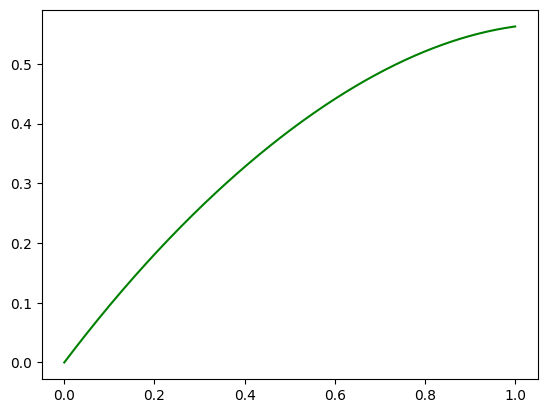

In [ ]:
tmin = 0
tmax = 1
N = 500
alpha0 = 1.1899
def exact_sol():
    T = np.linspace(tmin,tmax,N)
    return T, np.pi * np.sin(T)/ np.sin(1)

diffeq = Eq(x(t).diff(t, 2) + x(t).diff(t) + t**2, 0)
boundaries = [0, 1]

t_sol, x_sol = numeric_dsolve(tmin, tmax, N, diffeq, boundaries)

plt.plot(t_sol, x_sol, color = 'green')
# plt.plot(*exact_sol(), color = 'red', lw = 2, ls = '--')

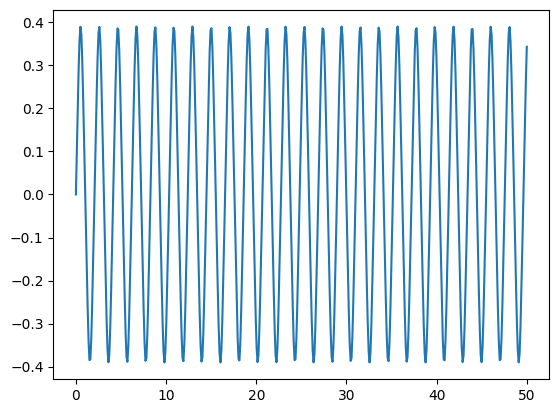

In [ ]:
t = symbols('t')
x = symbols('x', cls=Function)
t_sol, x_sol = numeric_dsolve(0, 50, 500, Eq(x(t).diff(t, 2)  + sin(x(t)) + 75*x(t)**3, 0), [0, 1])
plt.plot(t_sol, x_sol)

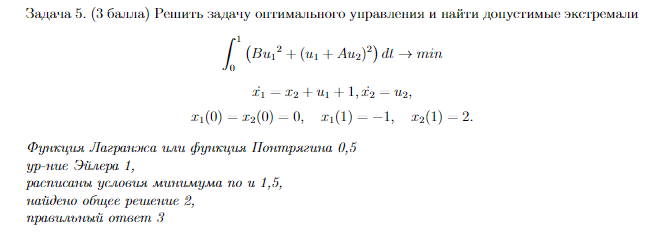

In [ ]:
# метод Лагранжа для задач управления и принцип Максимума Понтрягина
import numpy as np
from sympy import *
A, B = 1, 1
t = symbols('t')
u1, u2, x1, x2 = symbols('u_1 u_2 x_1 x_2', cls=Function)
tmin, tmax = 0, 1
diffeq1 = Eq(x1(t).diff(t) - x2(t) - u1(t) - 1, 0)
diffeq2 = Eq(x2(t).diff(t) - u2(t), 0)
p1, p2 = symbols('p_1 p_2', cls=Function)
f0 = B*u1(t)**2 + (u1(t) + A*u2(t))**2
# Выписываем функцию Лагранжа и терминальную функцию Лагранжа:
L = p1(t) * (diffeq1.lhs - diffeq1.rhs) + p2(t) * (diffeq2.lhs - diffeq2.rhs) + f0

InitCond1 = Eq(x1(tmin), 0)
InitCond2 = Eq(x2(tmin), 0)
InitCond3 = Eq(x1(tmax), -1)
InitCond4 = Eq(x2(tmax), 2)
InitCond2
lambda1, lambda2, lambda3, lambda4 = symbols('l1 l2 l3 l4')

def raz(a):
    return a.lhs - a.rhs
l = Add(*[A*x for A, x in zip([lambda1, lambda2, lambda3, lambda4],[raz(InitCond1), raz(InitCond2), raz(InitCond3), raz(InitCond4)])])

euler1 = Eq(L.diff(x1(t).diff(t)).diff(t), L.diff(x1(t)))
euler2 = Eq(L.diff(x2(t).diff(t)).diff(t), L.diff(x2(t)))

LagrangeUeq1 = Eq(L.diff(u1(t)), 0)
LagrangeUeq2 = Eq(L.diff(u2(t)), 0)

transvers = []

print(L)
for enum, arg in enumerate([tmin, tmax]):
    for x_ in [x1, x2]:
        transvers.append(Eq((L.diff(x_(t).diff(t))).subs({t: arg}), (-1)**enum * l.diff(x_(arg))))


solution_euler = dsolve([euler1, euler2], [p1(t), p2(t)] )
solution_euler

solution = solve([LagrangeUeq1, LagrangeUeq2], [u1(t), u2(t)] )
u1_star = solution[u1(t)].subs({p1(t) : solution_euler[0].rhs, p2(t) : solution_euler[1].rhs})
u2_star = solution[u2(t)].subs({p1(t) : solution_euler[0].rhs, p2(t) : solution_euler[1].rhs})
u2_star

diffeq1_ = diffeq1.subs({u1(t) : u1_star, u2(t) : u2_star})
diffeq2_ = diffeq2.subs({u1(t) : u1_star, u2(t) : u2_star})
solution_x = dsolve([diffeq1_, diffeq2_],[x1(t), x2(t)])



ConstEq = solve([solution_x[0].subs({t : tmin}).subs({InitCond1.lhs : InitCond1.rhs,InitCond2.lhs : InitCond2.rhs, InitCond3.lhs : InitCond3.rhs, InitCond4.lhs : InitCond4.rhs }),
                 solution_x[0].subs({t : tmax}).subs({InitCond1.lhs : InitCond1.rhs,InitCond2.lhs : InitCond2.rhs, InitCond3.lhs : InitCond3.rhs, InitCond4.lhs : InitCond4.rhs }),
                  solution_x[1].subs({t : tmin}).subs({InitCond1.lhs : InitCond1.rhs,InitCond2.lhs : InitCond2.rhs, InitCond3.lhs : InitCond3.rhs, InitCond4.lhs : InitCond4.rhs }),
                  solution_x[1].subs({t : tmax}).subs({InitCond1.lhs : InitCond1.rhs,InitCond2.lhs : InitCond2.rhs, InitCond3.lhs : InitCond3.rhs, InitCond4.lhs : InitCond4.rhs })])
ConstEq
# for i in range(len(solution_x)):
#   print(solution_x[i].subs(ConstEq))
Eq(L.diff(x1(t).diff(t)).subs({t:tmin}), l.diff(x1(tmin)))
Eq(L.diff(x2(t).diff(t)).subs({t:tmax}), -l.diff(x2(tmin)))
solution_euler
print([i.subs(ConstEq) for i in solution_euler])
print(solution_euler)
print(transvers)
transvers = [a.subs({lambda1: -6, lambda2: -4, lambda3: 6, lambda4: -2}) for a in transvers]
print(transvers)
solution_x[0].subs(ConstEq), solution_x[1].subs(ConstEq), u1_star.subs(ConstEq), u2_star.subs(ConstEq), [i.subs(ConstEq) for i in solution_euler]

(u_1(t) + u_2(t))**2 + (-u_2(t) + Derivative(x_2(t), t))*p_2(t) + (-u_1(t) - x_2(t) + Derivative(x_1(t), t) - 1)*p_1(t) + u_1(t)**2
[Eq(p_1(t), -6), Eq(p_2(t), 6*t - 4)]
[Eq(p_1(t), C1), Eq(p_2(t), -C1*t - C2)]
[Eq(p_1(0), l1), Eq(p_2(0), l2), Eq(p_1(1), -l3), Eq(p_2(1), -l4)]
[Eq(p_1(0), -6), Eq(p_2(0), -4), Eq(p_1(1), -6), Eq(p_2(1), 2)]


(Eq(x_1(t), t**3 - 2*t**2),
 Eq(x_2(t), 3*t**2 - t),
 -3*t - 1,
 6*t - 1,
 [Eq(p_1(t), -6), Eq(p_2(t), 6*t - 4)])

['p_1', 'p_2', 'u_1', 'u_2', 'x_1', 'x_2']
[p_1(1), p_1(2), p_1(3), p_1(4), p_1(5), p_1(6), p_1(7), p_1(8), p_1(9), p_1(10), p_1(11), p_1(12), p_1(13), p_1(14), p_1(15), p_1(16), p_1(17), p_1(18), p_1(19), p_1(20), p_1(21), p_1(22), p_1(23), p_1(24), p_1(25), p_1(26), p_1(27), p_1(28), p_1(29), p_1(30), p_1(31), p_2(1), p_2(2), p_2(3), p_2(4), p_2(5), p_2(6), p_2(7), p_2(8), p_2(9), p_2(10), p_2(11), p_2(12), p_2(13), p_2(14), p_2(15), p_2(16), p_2(17), p_2(18), p_2(19), p_2(20), p_2(21), p_2(22), p_2(23), p_2(24), p_2(25), p_2(26), p_2(27), p_2(28), p_2(29), p_2(30), p_2(31), u_1(1), u_1(2), u_1(3), u_1(4), u_1(5), u_1(6), u_1(7), u_1(8), u_1(9), u_1(10), u_1(11), u_1(12), u_1(13), u_1(14), u_1(15), u_1(16), u_1(17), u_1(18), u_1(19), u_1(20), u_1(21), u_1(22), u_1(23), u_1(24), u_1(25), u_1(26), u_1(27), u_1(28), u_1(29), u_1(30), u_2(1), u_2(2), u_2(3), u_2(4), u_2(5), u_2(6), u_2(7), u_2(8), u_2(9), u_2(10), u_2(11), u_2(12), u_2(13), u_2(14), u_2(15), u_2(16), u_2(17), u_2(18), u_

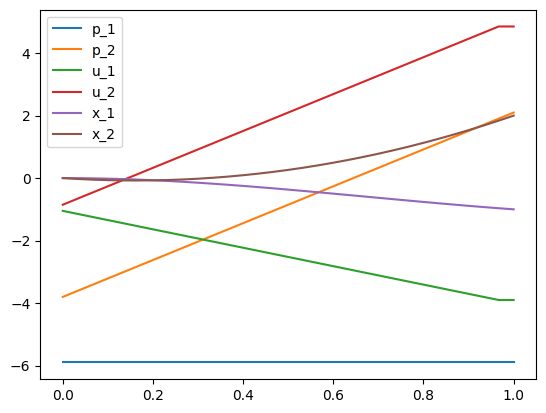

In [ ]:

# print(system)

def add_leading_nulls(s, N):
    return '0' * (N - len(s)) + s

def naive_extrapolation(l, N):
    return l + [l[-1] for _ in range(N - len(l))]

def main(system, boundaries):
    tmin = 0
    tmax = 1
    N = 30
    h = (tmax - tmin) / N
    finite_diff_dict = {
        # i == current state
        2: lambda y, h, i: (y.func(i-1) - 2 * y.func(i) + y.func(i+1))/ (h ** 2),
        1: lambda y, h, i: (y.func(i+1) - y.func(i)) / h,
        0: lambda y, h, i: y.func(i)
    }

    # kraevaya zadacha?
    diff_variables = set()
    functions = set()
    diff_order_total = {}
    for eq in system:
        deriv_degree_dict = {i: i.args[1][1]  for i in [*eq.find(Derivative)]}
        diff_order = max([*deriv_degree_dict.values()]) if len(deriv_degree_dict) > 0 else 0
        diff_variable = [i.args[0] for i in deriv_degree_dict.keys()]
        diff_variables.update(diff_variable)
        diff_order_total = diff_order_total | deriv_degree_dict
        functions.update(eq.find(Function))

    variables = functions - diff_variables
    # diff order total aldready done for diffeqs, now add variables
    diff_order_total = diff_order_total | {v: 0 for v in functions}

    # new arch
    i = Symbol('i')

    def gryaz(expr):
        return expr if expr in functions else expr.args[0]
    # y = {k: [Symbol(f'y_{k.name if k in functions else k.args[0].name}^{i}') for i in range(3)] for k in diff_order_total}
    linearized_subs = {k: finite_diff_dict[v](gryaz(k), h, i) for k,v in diff_order_total.items()}
    linearized_system = [eq.subs(linearized_subs) for eq in system]
    # print(linearized_system)
    # print(len(linearized_system))
    full_system = []
    setka_variables = set()
    for k in range(1,N+1):
        # dot_t = tmin + (k - 1) * h
        for eq in linearized_system:
            linearized_i = eq.subs({i: k})#.subs({b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1): b.rhs for b in boundaries})
            full_system.append(linearized_i)
            setka_variables.update(linearized_i.find(Function))

    full_system.extend([Eq(b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1), b.rhs) for b in boundaries])

    sorted_setka_variables = sorted(setka_variables,key=lambda i: i.name + '_' + add_leading_nulls(i.args[0].__str__(), len(str(N))), reverse=False)
    vars_names = sorted(set([i.name for i in sorted_setka_variables]), reverse=False)
    print(vars_names)
    print(sorted_setka_variables)

    # print(len(full_system))
    # print(full_system)
    # print(len(sorted_setka_variables))
    # print(sorted_setka_variables)
    sols = nsolve(full_system, sorted_setka_variables, [0 for _ in setka_variables])
    # sols = solve(full_system, sorted_setka_variables)
    mapping = {k: v for k,v in zip(sorted_setka_variables, sols)}

    ret = {vars_names[i]: naive_extrapolation([v for k,v in mapping.items() if vars_names[i] in k.name], N+1) for i in range(len(vars_names))}



    # vars = [[*sols.values()][(N+1)*i:(N+1)*(i+1)] for i in range(len(vars_names))]
    # ret = {vars_names[i]: vars[i] for i in range(len(vars_names))}
    print(ret)
    T = np.linspace(tmin, tmax, N+1)
    return T, ret, vars_names

#-----------------

system = [diffeq1, diffeq2, euler1, euler2, LagrangeUeq1, LagrangeUeq2] # -- пока сложно сделать разностную схему
boundaries = [InitCond1,InitCond2,InitCond3,InitCond4]#,*transvers]
T, ret, vars_names = main(system, boundaries)
for i in range(len(ret)):
    plt.plot(T, ret[vars_names[i]], label=vars_names[i])
plt.legend()
plt.show()

# plt.plot(T, np.linspace(-6,-6,N-1))
# plt.plot(T, 6*t-2)

16

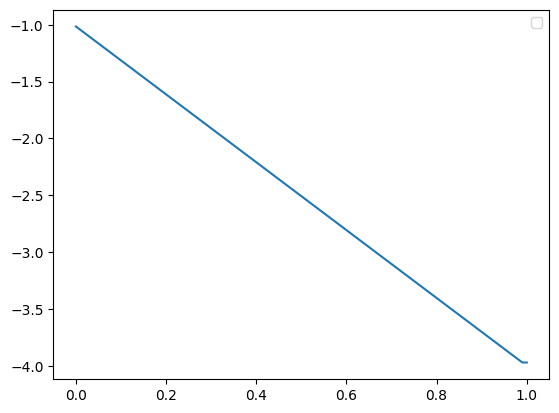

In [ ]:
i = 5
plt.plot(T, ret['u_1'])
plt.legend()

# Решение НЕлинейной краевой задачи, методом стрелбы


In [ ]:
# Решение НЕлинейной краевой задачи, методом стрелбы
# Область применимости:
# Граничные условия --- только 1-го рода:   x(tmin) = a, x(tmax) = b
# Диффуры ---

import numpy as np
from sympy import *
from itertools import chain

t = symbols('t')
x = symbols('x', cls=Function)
def shooting_method(tmin, tmax, N, steps, alpha0, diffeq, boundaries):
    h = (tmax - tmin) / N
    t_sol, x_sol = numeric_dsolve(tmin, tmax, N, diffeq , [boundaries[0], alpha0])
    t_sol_h, x_sol_h = numeric_dsolve(tmin, tmax, N, diffeq, [boundaries[0], alpha0+h])
    alpha = [alpha0]
    for n in range(steps):
        alpha_n = alpha[-1] - ((x_sol[-1] - boundaries[1])*h / (x_sol_h[-1] - x_sol[-1]))
        alpha.append(alpha_n)
        t_sol, x_sol = numeric_dsolve(tmin, tmax, N, diffeq, [boundaries[0], alpha[-1]])
        t_sol_h, x_sol_h = numeric_dsolve(tmin, tmax, N, diffeq, [boundaries[0], alpha[-1]+h])

    return t_sol, x_sol

# тесты метода стрельбы

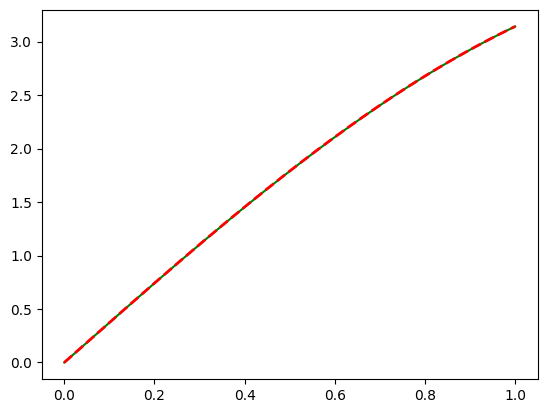

In [ ]:
tmin = 0
tmax = 1
N = 500
alpha0 = 1.1899
steps = 2
def exact_sol():
    T = np.linspace(tmin,tmax,N)
    return T, np.pi * np.sin(T)/ np.sin(1)

diffeq = Eq(x(t).diff(t, 2)  + x(t), 0)
boundaries = [0, np.pi]

t_sol, x_sol = shooting_method(tmin, tmax, N, steps, alpha0, diffeq, boundaries)

plt.plot(t_sol, x_sol, color = 'green')
plt.plot(*exact_sol(), color = 'red', lw = 2, ls = '--')


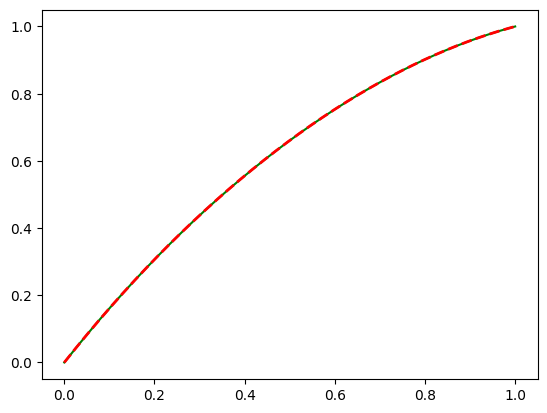

In [ ]:
tmin = 0
tmax = 1
N = 500
alpha0 = 1.1899
steps = 5
def exact_sol():
    T = np.linspace(tmin,tmax,N)
    return T, -(-7 * np.e ** (1 - T) + T * (6 - 3 * T + T**2) - np.e * (-7 + 6 * T - 3 * T**2 + T**3))/(3 - 3 * np.e)

diffeq = Eq(x(t).diff(t, 2) + x(t).diff(t) + t**2, 0)
boundaries = [0, 1]

t_sol, x_sol = shooting_method(tmin, tmax, N, steps,  alpha0, diffeq, boundaries)

plt.plot(t_sol, x_sol, color = 'green')
plt.plot(*exact_sol(), color = 'red', lw = 2, ls = '--')


#Предварительная версия **Variable Task Solver (VTS)**:

In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from sympy.core.function import AppliedUndef
import time

In [ ]:
### Численный солвер main

def main(system, boundaries, tmin, tmax):
    def add_leading_nulls(s, N):
      return '0' * (N - len(s)) + s

    def naive_extrapolation(l, N):
      return l + [l[-1] for _ in range(N - len(l))]

    N = 25
    h = (tmax - tmin) / N
    finite_diff_dict = {
        # i == current state
        2: lambda y, h, i: (y.func(i-1) - 2 * y.func(i) + y.func(i+1))/ (h ** 2),
        1: lambda y, h, i: (y.func(i+1) - y.func(i)) / h,
        0: lambda y, h, i: y.func(i)
    }
    # kraevaya zadacha?
    diff_variables = set()
    functions = set()
    diff_order_total = {}
    for eq in system:
        deriv_degree_dict = {i: i.args[1][1]  for i in [*eq.find(Derivative)]}
        diff_order = max([*deriv_degree_dict.values()]) if len(deriv_degree_dict) > 0 else 0
        diff_variable = [i.args[0] for i in deriv_degree_dict.keys()]
        diff_variables.update(diff_variable)
        diff_order_total = diff_order_total | deriv_degree_dict
        functions.update(eq.find(Function))

    vremya = {i.args[0] for i in diff_variables}.pop()
    variables = functions - diff_variables
    # diff order total aldready done for diffeqs, now add variables
    diff_order_total = diff_order_total | {v: 0 for v in functions}

    # new arch
    i = Symbol('i')

    def gryaz(expr):
        return expr if expr in functions else expr.args[0]
    linearized_subs = {k: finite_diff_dict[v](gryaz(k), h, i) for k,v in diff_order_total.items()}
    linearized_subs |= {vremya: tmin + i*h}
    linearized_system = [eq.subs(linearized_subs) for eq in system]
    #print(linearized_system)
    full_system = []
    setka_variables = set()
    for k in range(1,N+1):
        for eq in linearized_system:
            linearized_i = eq.subs({i: k})#.subs({b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1): b.rhs for b in boundaries})
            full_system.append(linearized_i)
            setka_variables.update(linearized_i.find(AppliedUndef))

    full_system.extend([Eq(b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1), b.rhs) for b in boundaries])
    sorted_setka_variables = sorted(setka_variables,key=lambda i: i.name + '_' + add_leading_nulls(i.args[0].__str__(), len(str(N))), reverse=False)
    vars_names = sorted(set([i.name for i in sorted_setka_variables]), reverse=False)
    sols = nsolve(full_system, sorted_setka_variables, [0 for _ in setka_variables])
    mapping = {k: v for k,v in zip(sorted_setka_variables, sols)}
    ret = {vars_names[i]: naive_extrapolation([v for k,v in mapping.items() if vars_names[i] in k.name], N+1) for i in range(len(vars_names))}
    T = np.linspace(tmin, tmax, N+1)
    return T, ret, vars_names

In [ ]:
##### Объявление переменных и вариационной задачи с ГУ

a, b, c, m, t, w, e = symbols('a b c m t w e', real = True, positive = True)
x,y,z,u,v, L, A = symbols('x y z u v L A', cls=Function)

#L = 2*(x(t).diff(t))**2 / 2 - 8*x(t)
#I = Integral(L, (t, 0, 1))
#B = [  [Eq(x(float(list(I.args[1])[1]) ),1), Eq(x(float(list(I.args[1])[2]) ), 1)] ]

#L = m*((x(t).diff(t))**2) / 2 - m*w**2*x(t)**2 / 2 + m*((y(t).diff(t))**2) / 2 - m*a**2*y(t)**2 / 2 + m*((z(t).diff(t))**2) / 2 - m*b**2*z(t)**2 / 2
#I = Integral(L, (t, 0, pi/2))
#B = [  [Eq(x(0),0), Eq(x(pi/2), 1)], [Eq(y(0),0), Eq(y(pi/2), 0)], [Eq(z(0),0), Eq(z(pi/2), 1)] ]

L = 1*((x(t).diff(t))**2) / 2 - 1*2**2*x(t)**2 / 2 + 1*((y(t).diff(t))**2) / 2 - 1*2**2*y(t)**2 / 2 + 1*((z(t).diff(t))**2) / 2 - 1*2**2*z(t)**2 / 2
I = Integral(L, (t, 0, pi/2))
B = [  [Eq(x(0),0), Eq(x(pi/2), 1)], [Eq(y(0),0), Eq(y(pi/2), 0)], [Eq(z(0),0), Eq(z(pi/2), 1)] ]

#L = (x(t).diff(t))**2 * sin(t) + 2*x(t)*cos(t)
#I = Integral(L, (t, pi/4, pi/2))
#B = [  [Eq(x(list(I.args[1])[1]),0), Eq(x(list(I.args[1])[2]), pi/4)] ]

#L = 2*t*x(t)**2 + 2*t**2 * x(t) * x(t).diff(t) + t**2 * x(t).diff(t)**2 + 12*t**2 * x(t)
#I = Integral(L, (t, 1, 2))
#B = [  [Eq(x(list(I.args[1])[1]),2), Eq(x(list(I.args[1])[2]), 5)] ]

#L = t**2 * x(t) * x(t).diff(t) + 8*t**2 *x(t) - t**2 * (x(t).diff(t))**2 + (t-2)*x(t)**2
#B = [  [Eq(x(2),0), Eq(x(4), -8)] ]

#L = x(t).diff(t)**2 + 3*x(t)**2 / (4 * t**2)
#B = [  [Eq(x(1),1), Eq(x(4), 8)] ]

#L = ( x(t).diff(t) / x(t) )**2 - t*x(t).diff(t) - t
#B = [  [Eq(x(0),1), Eq(x(1), exp(-1))] ]

#L = x(t)**2 + x(t).diff(t)**2 - y(t)**2 + y(t).diff(t)
#I = Integral(L, (t, 0, 1))
#B = [  [Eq(x(list(I.args[1])[1] ),0), Eq(x(list(I.args[1])[2]), 6)], [Eq(y(list(I.args[1])[1] ),5), Eq(y(list(I.args[1])[2] ), 3)] ]

In [ ]:
def VTS_max_final(Integralus, Boundaries):

    t = Integralus.args[1][0]
    horizon = list(Integralus.args[1][1:])
    L = Integralus.args[0]
    variables = list(L.atoms(AppliedUndef))
    display(Latex(rf"{ latex( L ) }"))

    def announce_boundaries(variable, Boundaries):
        boundary_dots = [list((Boundaries[0].args[0]).args)[0],list((Boundaries[1].args[0]).args)[0]] ## list((Boundaries[1].args[0]).args)[0] вот эта грязь выдает точку в которой задано ПРАВОЕ ГУ
        FirstBoundEq = Eq(variable.subs(t, boundary_dots[0]), Boundaries[0].args[1]) ### Boundaries[1].args[1] а эта грязь выдает значение, заданное в правой точке
        SecondBoundEq = Eq(variable.subs(t, boundary_dots[1]), Boundaries[1].args[1])
        return boundary_dots, FirstBoundEq, SecondBoundEq

    def boundary_conditions(variables):
        boundary_conditions = []
        for i in range(len(variables)):
            boundary_conditions.append( announce_boundaries(variables[i], Boundaries[i])  )
        return boundary_conditions

    def simpliest_variation_problem(L,variables):
        EulerLagrangeEqs = []
        for var in variables:
            EulerLagrangeEqs.append( Eq(L.diff(var), (L.diff(var.diff(t))).diff(t))  )
        return EulerLagrangeEqs

    def boundary_numeric(Boundaries):
        boundary_for_numeric = []
        for b in Boundaries:
          for i in range(len(b)):
            boundary_for_numeric.append(b[i])
        return boundary_for_numeric
    boundary_for_numeric = boundary_numeric(Boundaries)


    Lagrange = simpliest_variation_problem(L,variables)
    display(Latex(rf"{ latex( Lagrange ) }"))
    boundary_conditions = boundary_conditions(variables)
    display(Latex(rf"{ latex( boundary_conditions ) }"))
    display(Latex(rf"{ latex( variables ) }"))
    def sanitized_diffeqs(Lagrange):
        sanitized_diffeqs  = []
        for d in Lagrange:
            #display(Latex(rf"{ latex( d ) }"))
            for v in variables:
                #display(Latex(rf"{ latex( d.find(Derivative) ) }"))
                subs_dict = {k: Dummy('q') for k in d.find(Derivative)}
                display(Latex(rf"{ latex( subs_dict ) }"))
                d_ = d.subs(subs_dict)
                #display(Latex(rf"{ latex( d_ ) }"))
                d_ = factor(d_.lhs - d_.rhs, v)
                wild = Wild('wild')
                if (wild * v).matches(d_):
                    d = simplify(Eq(d.lhs / v, d.rhs / v))
            sanitized_diffeqs.append(d)
        return sanitized_diffeqs
    try:
        if len(Lagrange) == 1:
            Solution = [dsolve(Lagrange[0])]
        else:
            counter = np.sum([1 for eq in Lagrange if eq.find(Derivative)])
            if counter == len(Lagrange):
                Solution = dsolve(Lagrange, variables)
            elif counter == 0:
                Solution = solve(Lagrange, variables)
            else:
                display(Latex(rf"{ latex( boundary_for_numeric ) }"))
                T, ret, vars_names = main(Lagrange, boundary_for_numeric,horizon[0], horizon[1])
    except NotImplementedError:
        T, ret, vars_names = main(Lagrange, boundary_for_numeric,horizon[0], horizon[1])
        for i in range(len(ret)):
            plt.scatter(T, ret[vars_names[i]][1::], label=vars_names[i])

    #display(Latex(rf"{ latex( boundary_conditions ) }"))
    #display(Latex(rf"{ latex( Solution ) }"))
    #print(  (boundary_conditions[0][2].args[0]) , 'значения')
    def constants_solution(Solution, boundary_conditions):
        ConstEqs = []
        for i in range(len(variables)):
            ConstEqs.append(  Eq( (Solution[i].rhs).subs(t, (boundary_conditions[0][1].args[0]).args[0] ), boundary_conditions[i][1].rhs) )
            ConstEqs.append(  Eq( (Solution[i].rhs).subs(t, (boundary_conditions[0][2].args[0]).args[0] ), boundary_conditions[i][2].rhs) )
            #display(Latex(rf"{ latex( ConstEqs ) }"))
        const_sol = solve(ConstEqs, dict = True)
        return const_sol[0] # одно решение у линейной системы

    const_sol = constants_solution(Solution, boundary_conditions)
    display(Latex(rf"{ latex( const_sol ) }"))
    def FinalSolution(Solution, const_sol, variables):
        FinalSolution = []
        for i in range(len(variables)):
            FinalSolution.append(simplify(Solution[i].subs(const_sol)))
        return FinalSolution

    FinalSolution = FinalSolution(Solution, const_sol, variables)
    display(Latex(rf"{ latex( FinalSolution ) }"))

    ### Сравнение численного счёта с символьным решением (потом удалить) ###
    T, ret, vars_names = main(Lagrange, boundary_for_numeric,float(horizon[0]), float(horizon[1]))
    for i in range(len(ret)):
      plt.scatter(T, ret[vars_names[i]][1::], label=vars_names[i])

    lam_f = lambdify(t, FinalSolution[0].rhs)
    t = np.linspace(float(horizon[0]), float(horizon[1]), 100)

    plt.plot(t, lam_f(t), color = 'blue', lw = 2 )
    ########################################################################

In [ ]:
VTS_max_final(I, B)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

IndexError: list index out of range

# VTS by chainedgenius

# imports + main numerical solver

In [ ]:
from sympy import *
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from sympy.core.function import AppliedUndef
import time
from itertools import chain
import warnings
### Численный солвер main

def main(system, boundaries, tmin, tmax):
    def add_leading_nulls(s, N):
      return '0' * (N - len(s)) + s

    def naive_extrapolation(l, N):
      return l + [l[-1] for _ in range(N - len(l))]

    N = 25
    h = (tmax - tmin) / N
    finite_diff_dict = {
        # i == current state
        2: lambda y, h, i: (y.func(i-1) - 2 * y.func(i) + y.func(i+1))/ (h ** 2),
        1: lambda y, h, i: (y.func(i+1) - y.func(i)) / h,
        0: lambda y, h, i: y.func(i)
    }
    # kraevaya zadacha?
    diff_variables = set()
    functions = set()
    diff_order_total = {}
    for eq in system:
        deriv_degree_dict = {i: i.args[1][1]  for i in [*eq.find(Derivative)]}
        diff_order = max([*deriv_degree_dict.values()]) if len(deriv_degree_dict) > 0 else 0
        diff_variable = [i.args[0] for i in deriv_degree_dict.keys()]
        diff_variables.update(diff_variable)
        diff_order_total = diff_order_total | deriv_degree_dict
        functions.update(eq.find(Function))

    vremya = {i.args[0] for i in diff_variables}.pop()
    variables = functions - diff_variables
    # diff order total aldready done for diffeqs, now add variables
    diff_order_total = diff_order_total | {v: 0 for v in functions}

    # new arch
    i = Symbol('i')

    def gryaz(expr):
        return expr if expr in functions else expr.args[0]
    linearized_subs = {k: finite_diff_dict[v](gryaz(k), h, i) for k,v in diff_order_total.items()}
    linearized_subs |= {vremya: tmin + i*h}
    linearized_system = [eq.subs(linearized_subs) for eq in system]
    #print(linearized_system)
    full_system = []
    setka_variables = set()
    for k in range(1,N+1):
        for eq in linearized_system:
            linearized_i = eq.subs({i: k})#.subs({b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1): b.rhs for b in boundaries})
            full_system.append(linearized_i)
            setka_variables.update(linearized_i.find(AppliedUndef))

    full_system.extend([Eq(b.lhs.func(Integer((b.lhs.args[0] - tmin)/h)+1), b.rhs) for b in boundaries])
    sorted_setka_variables = sorted(setka_variables,key=lambda i: i.name + '_' + add_leading_nulls(i.args[0].__str__(), len(str(N))), reverse=False)
    vars_names = sorted(set([i.name for i in sorted_setka_variables]), reverse=False)
    sols = nsolve(full_system, sorted_setka_variables, [0 for _ in setka_variables])
    mapping = {k: v for k,v in zip(sorted_setka_variables, sols)}
    ret = {vars_names[i]: naive_extrapolation([v for k,v in mapping.items() if vars_names[i] in k.name], N+1) for i in range(len(vars_names))}
    T = np.linspace(tmin, tmax, N+1)
    return T, ret, vars_names

# vts tests + main

In [ ]:
##### Объявление переменных и вариационной задачи с ГУ

a, b, c, m, t, w, e = symbols('a b c m t w e', real = True, positive = True)
x,y,z,u,v, L, A = symbols('x y z u v L A', cls=Function)

# L = 2*(x(t).diff(t))**2 / 2 - 8*x(t)
# I = Integral(L, (t, 0, 1))
# B = [  [Eq(x(float(list(I.args[1])[1]) ),1), Eq(x(float(list(I.args[1])[2]) ), 1)] ]

# L = m*((x(t).diff(t))**2) / 2 - m*w**2*x(t)**2 / 2 + m*((y(t).diff(t))**2) / 2 - m*a**2*y(t)**2 / 2 + m*((z(t).diff(t))**2) / 2 - m*b**2*z(t)**2 / 2
# I = Integral(L, (t, 0, pi/2))
# B = [  [Eq(x(0),0), Eq(x(pi/2), 1)], [Eq(y(0),0), Eq(y(pi/2), 0)], [Eq(z(0),0), Eq(z(pi/2), 1)] ]

# L = 1*((x(t).diff(t))**2) / 2 - 1*2**2*x(t)**2 / 2 + 1*((y(t).diff(t))**2) / 2 - 1*2**2*y(t)**2 / 2 + 1*((z(t).diff(t))**2) / 2 - 1*2**2*z(t)**2 / 2
# I = Integral(L, (t, 0, pi/8))
# B = [  [Eq(x(0),0), Eq(x(pi/8), 1)], [Eq(y(0),0), Eq(y(pi/8), 0)], [Eq(z(0),0), Eq(z(pi/8), 1)] ]

# L = (x(t).diff(t))**2 * sin(t) + 2*x(t)*cos(t)
# I = Integral(L, (t, pi/4, pi/2))
# B = [  [Eq(x(list(I.args[1])[1]),0), Eq(x(list(I.args[1])[2]), pi/4)] ]

# L = 2*t*x(t)**2 + 2*t**2 * x(t) * x(t).diff(t) + t**2 * x(t).diff(t)**2 + 12*t**2 * x(t)
# I = Integral(L, (t, 1, 2))
# B = [  [Eq(x(list(I.args[1])[1]),2), Eq(x(list(I.args[1])[2]), 5)] ]

L = t**2 * x(t) * x(t).diff(t) + 8*t**2 *x(t) - t**2 * (x(t).diff(t))**2 + (t-2)*x(t)**2
I = Integral(L, (t, 2, 4))
B = [  [Eq(x(list(I.args[1])[1]),0), Eq(x(list(I.args[1])[2]), -8)] ]

#L = x(t).diff(t)**2 + 3*x(t)**2 / (4 * t**2)
#I = Integral(L, (t, 1, 4))
#B = [  [Eq(x(list(I.args[1])[1]),1), Eq(x(list(I.args[1])[2]), 8)] ]

#L = ( x(t).diff(t) / x(t) )**2 - t*x(t).diff(t) - t
#I = Integral(L, (t, 0, 1))
#B = [  [Eq(x(list(I.args[1])[1]),1), Eq(x(list(I.args[1])[2]), exp(-1))] ]                 ################# Не работает, если в знаменателе ноль появляется

#L = x(t)**2 + x(t).diff(t)**2 - y(t)**4 / 3 + y(t).diff(t)**2
#I = Integral(L, (t, 0, 1))
#B = [  [Eq(x(list(I.args[1])[1] ),0), Eq(x(list(I.args[1])[2]), 6)], [Eq(y(list(I.args[1])[1] ),5), Eq(y(list(I.args[1])[2] ), 3)] ]

In [ ]:
class Updateable(object):
    def update(self, new):
        for key, value in new.__dict__.items():
            if hasattr(self, key) and value is not None:
                setattr(self, key, value)
@dataclass
class OutputTemplate(Updateable):
    formula: list() #list of Eq, add typing here
    values: list()
    t_list: list()
    range: list()

def list_reinit(obj):
    if isinstance(obj, list):
        return obj
    else:
        return [obj]

def mydisplay(expr):
    display(Latex(latex(expr)))

def get_euler_lagrange_equations(L,variables):
    EulerLagrangeEqs = []
    for var in variables:
        EulerLagrangeEqs.append( Eq(L.diff(var), (L.diff(var.diff(t))).diff(t))  )
    return EulerLagrangeEqs

def constants_solution(Solution, boundary_conditions):
    ret = []
    solution_transform = {s.lhs.func: s.rhs for s in Solution}
    for b in boundary_conditions:
        subs_dict = {fnc: solution_transform[fnc.func].subs(t, fnc.args[0]) for fnc in b.find(AppliedUndef)}
        ret.append(b.subs(subs_dict))
    const_sol = solve(ret, dict = True)
    return const_sol[0]

def VTS_max_final(Integralus, Boundaries, forced_numeric=True, check_sync=True):
    t = Integralus.args[1][0]
    horizon = list(Integralus.args[1][1:])
    L = Integralus.args[0]
    variables = list(L.atoms(AppliedUndef))
    free_symbols = L.free_symbols - {t}
    Lagrange = get_euler_lagrange_equations(L,variables)
    counter = np.sum([1 for eq in Lagrange if eq.find(Derivative)])

    config_dict = {}
    if free_symbols:
        for v in free_symbols:
            config_dict[v] = input(f'Введите числовое значение для {v}:')

    final_numeric_ret = OutputTemplate(formula=None, values=None, t_list=None, range=horizon)
    if forced_numeric:
        T, ret, vars_names = main([i.subs(config_dict) for i in Lagrange], Boundaries, float(horizon[0]), float(horizon[1]))
        final_numeric_ret = OutputTemplate(formula=None, values=ret, t_list=T, range=horizon)


    if counter == len(Lagrange): #diff system only
        mydisplay(Lagrange)
        Solution = dsolve(Lagrange, variables)

        const_sol = constants_solution(Solution, Boundaries)
        FinalSolution = [i.subs(const_sol) for i in Solution]
        final_symbolic_ret = OutputTemplate(formula=FinalSolution, values=None, range=horizon, t_list=None)

    elif counter == 0: #algebraic system
        Solution = solve(Lagrange, variables)
        const_sol = constants_solution(Solution, Boundaries)
        FinalSolution = [i.subs(const_sol) for i in Solution]
        final_symbolic_ret = OutputTemplate(formula=FinalSolution, values=None, range=horizon, t_list=None)

    ret = OutputTemplate(formula=None, values=None, t_list=None, range=horizon)
    ret.update(final_symbolic_ret)


    if final_numeric_ret.values:
        ret.update(final_numeric_ret)
    else:
        applied_func_vals = {}
        for symb_ret in ret.formula:
            symb_ret_func = lambdify(t, symb_ret.rhs.subs(config_dict))
            symb_ret_values = symb_ret_func(T)
            applied_func_vals[symb_ret.lhs.func.name] = symb_ret_values
        final_apply_symbolic_ret = OutputTemplate(formula=None, values=applied_func_vals, t_list=None, range=horizon)
        ret.update(final_apply_symbolic_ret)


    if check_sync and forced_numeric:
        cum_mse_error = 0
        T = ret.t_list
        for symb_ret in ret.formula:
            symb_ret_func = lambdify(t, symb_ret.rhs.subs(config_dict))
            symb_ret_values = symb_ret_func(T)
            cum_mse_error += np.square(np.subtract(symb_ret_values, ret.values[symb_ret.lhs.func.name][:len(T)])).mean()

        print('Cummulative MSE error of symbolic and numeric outputs:', cum_mse_error)

    return ret

def visualize(obj: OutputTemplate):
    ngraphs = len(obj.values)
    t = obj.t_list
    if ngraphs > 1:
        fig, axs = plt.subplots(ngraphs, 1)
        for i, its in enumerate(obj.values.items()):
            axs[i].plot(t, its[1][:len(t)])
            axs[i].set_title(its[0])
        fig.show()
    else:
        its = [*obj.values.items()][0]
        fig = plt.plot(t, its[1][:len(t)])
        plt.title(its[0])
        plt.show()

ret = VTS_max_final(I, [*chain(*B)], forced_numeric=True)
visualize(ret)

<IPython.core.display.Latex object>

ValueError: Matrix A should not depend on t